# Práctica 1: cadenas de Markov como Modelos de Secuencias

Usaremos el paquete `hidden_markov`



In [1]:
#pip install hidden_markov

In [1]:
# Import required Libraries
import numpy as np
from hidden_markov import hmm
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
### Also http://scikit-learn.sourceforge.net/stable/modules/hmm.html

## Ejemplo 1: Conjunto de datos

Cargamos datos de secuencias de proteínas.

Carga el conjunto de datos ``prots-L30.txt`` que puedes descargar en Moodle. Como vamos a trabajar con cadenas de caracteres, convierte todas las columnas que involucren cadenas de caracteres al tipo character. Visualiza el conjunto de datos. La primera columna se refiere al identificador de la proteina en PDB. La segunda es la secuencia de aminoácidos, y la tercera es la estructura secundaria más probable predicha para esa secuencia en la base de datos. La cuarta columna es la longitud de la secuencia.

¿Tienen todas las secuencias la misma longitud?


In [4]:
dataFolder = './data/'
dataFile = 'prots-L30.txt'
dataFilepath = os.path.join(dataFolder,dataFile)
df = pd.read_csv(dataFilepath)
df.head()

,pdb_id,seq,sst3,len
0,1AI0,FVNQHLCGSHLVEALYLVCGERGFFYTPKT,CCCHHHHHHHHHHHHHHHHHHHCEEECCCC,30
1,1APH,FVNQHLCGSHLVEALYLVCGERGFFYTPKA,CCCCCCCCHHHHHHHHHHHHHHCEEECCCC,30
2,1B4G,MISSVCVSSYRGRKSGNKPPSKTCLKEEMA,CCCCCECCCCCCCCCCCCCCCCCCCCCCCC,30
3,1B9E,FVNQHLCGEHLVEALYLVCGERGFFYTPKT,CCCCCCCHHHHHHHHHHHHHHHCEEECCCC,30
4,1BH4,CGESCVWIPCISAALGCSCKNKVCYRNGIP,CCCCCCCCCCCHHHHCCCCCCCCCCCCCCC,30


In [5]:
df.describe()

,len
count,174.0
mean,30.0
std,0.0
min,30.0
25%,30.0
50%,30.0
75%,30.0
max,30.0


In [6]:
df.dtypes

pdb_id    object
seq       object
sst3      object
len        int64
dtype: object

In [7]:
df.seq[0]

'FVNQHLCGSHLVEALYLVCGERGFFYTPKT'

In [8]:
type(df.seq[0])

str

## Ejemplo 2. Definiciones previas.

Define el alfabeto, formado por 20 aminoácidos, siguiendo este orden: ``RKDEQSCHNTWYMAILFVPG``. Obtén las longitudes del alfabeto y la longitud de cada secuencia, así como el numero de instancias en el conjunto de datos.

In [9]:
alfabeto=[ele for ele in "RKDEQSCHNTWYMAILFVPG"]

In [10]:
print('Longitud del alfabeto ={}\nNúmero de secuencias ={}\nLongitud de las secuencias = {}'.format(len(alfabeto),
                               len(df['seq']),len(df['seq'][0])))

Longitud del alfabeto =20
Número de secuencias =174
Longitud de las secuencias = 30


## Ejemplo 3. Vector de frecuencias en la primera posición

Vamos a calcular las probabilidades iniciales de cada aminoácido.

> Calcula las frecuencias absolutas de cada aminoacido en la primera posición de la secuencia.

In [11]:
numSecuencias = len(df['seq'])
lenAlfab = len(alfabeto)
#frecAbsoluPos1 = [0 for i in range(lenAlfab)]
Pini = np.zeros(lenAlfab).astype(float)

for nseq in range(numSecuencias):
    secuenciaTabla = df.loc[nseq,'seq']
    primerAminoacido = secuenciaTabla[0]
    posicionAlfabeto = alfabeto.index(primerAminoacido)
    Pini[posicionAlfabeto] += 1

frecuenciasAbsolutasIniciales = dict(zip(alfabeto,Pini))
frecuenciasAbsolutasIniciales

{'R': 2.0,
 'K': 10.0,
 'D': 6.0,
 'E': 8.0,
 'Q': 3.0,
 'S': 8.0,
 'C': 9.0,
 'H': 3.0,
 'N': 3.0,
 'T': 3.0,
 'W': 0.0,
 'Y': 3.0,
 'M': 15.0,
 'A': 21.0,
 'I': 1.0,
 'L': 2.0,
 'F': 39.0,
 'V': 9.0,
 'P': 5.0,
 'G': 24.0}

## Ejercicio 1. Vector inicial de probabilidades

Comprueba que la suma del vector calculado
en el ejemplo anterior coincide con el número de instancias. Normaliza el vector dividiendo
por la suma para transformarlo en un vector de probabilidades.

In [12]:
print('Suma de Pini: {}\nNúmero de secuencias: {}'.format(sum(Pini),numSecuencias))
sum(Pini),numSecuencias
# Frecuencias Relativas
sumFrecuenciasAbsolutas = sum(Pini)
Pini = Pini/sumFrecuenciasAbsolutas
print('\n')
print(Pini,Pini.sum())
frecuenciasRelativasIniciales = dict(zip(alfabeto,Pini))
print('\n')
print(frecuenciasRelativasIniciales)

Suma de Pini: 174.0
Número de secuencias: 174


[0.01149425 0.05747126 0.03448276 0.04597701 0.01724138 0.04597701
 0.05172414 0.01724138 0.01724138 0.01724138 0.         0.01724138
 0.0862069  0.12068966 0.00574713 0.01149425 0.22413793 0.05172414
 0.02873563 0.13793103] 1.0


{'R': 0.011494252873563218, 'K': 0.05747126436781609, 'D': 0.034482758620689655, 'E': 0.04597701149425287, 'Q': 0.017241379310344827, 'S': 0.04597701149425287, 'C': 0.05172413793103448, 'H': 0.017241379310344827, 'N': 0.017241379310344827, 'T': 0.017241379310344827, 'W': 0.0, 'Y': 0.017241379310344827, 'M': 0.08620689655172414, 'A': 0.1206896551724138, 'I': 0.005747126436781609, 'L': 0.011494252873563218, 'F': 0.22413793103448276, 'V': 0.05172413793103448, 'P': 0.028735632183908046, 'G': 0.13793103448275862}


## Ejercicio 2. Matriz de Transiciones

Define una matriz de ceros, de tamaño $20 \times 20$, de forma que los nombres de filas y columnas sean precisamente los nombres de cada aminoácido. 

Actualiza esta matriz para que contenga las frecuencias absolutas de las $20 \times 20$ posibles transiciones que hay entre los aminoácidos. Para ello tendrás que recorrer cada secuencia e identificar los dos residuos $R_i \rightarrow R_f$ involucrados en las 29 transiciones posibles (tenemos secuencias de longitud 30) y actualizar el contador en la fila y columna correspondientes a la transición observada. Habrá que acumular los conteos
recorriendo todas las secuencias del conjunto de datos.


In [13]:
columns = alfabeto
rows = alfabeto
MT = pd.DataFrame(0.0,columns=columns,index=rows) # inicializamos como float
for nseq in range(df.shape[0]):
    secuencia = df.loc[nseq,'seq']
    for naa in range(len(secuencia)-1): # recorremos hasta el penultimo
        pos1 = secuencia[naa]
        pos2 = secuencia[naa+1]
        MT.loc[pos1,pos2]+=1
MT

,R,K,D,E,Q,S,C,H,N,T,W,Y,M,A,I,L,F,V,P,G
R,32.0,14.0,6.0,10.0,9.0,6.0,12.0,5.0,7.0,9.0,3.0,17.0,2.0,18.0,24.0,29.0,5.0,4.0,15.0,52.0
K,17.0,27.0,7.0,21.0,10.0,20.0,17.0,10.0,12.0,49.0,3.0,6.0,1.0,18.0,9.0,13.0,2.0,11.0,23.0,12.0
D,4.0,9.0,15.0,6.0,4.0,16.0,12.0,4.0,5.0,5.0,2.0,5.0,1.0,7.0,7.0,17.0,3.0,9.0,12.0,13.0
E,71.0,29.0,16.0,16.0,5.0,11.0,7.0,3.0,8.0,7.0,2.0,8.0,1.0,52.0,14.0,15.0,4.0,9.0,4.0,13.0
Q,9.0,11.0,4.0,8.0,6.0,3.0,12.0,35.0,4.0,4.0,1.0,12.0,0.0,12.0,10.0,8.0,1.0,3.0,3.0,18.0
S,10.0,27.0,20.0,10.0,9.0,21.0,35.0,34.0,11.0,8.0,7.0,12.0,3.0,12.0,8.0,17.0,5.0,9.0,12.0,25.0
C,26.0,24.0,14.0,10.0,12.0,33.0,36.0,0.0,5.0,24.0,1.0,25.0,4.0,24.0,43.0,8.0,2.0,19.0,16.0,89.0
H,1.0,4.0,1.0,3.0,1.0,12.0,7.0,6.0,1.0,2.0,0.0,2.0,4.0,5.0,7.0,68.0,1.0,5.0,0.0,2.0
N,15.0,5.0,4.0,4.0,43.0,4.0,6.0,0.0,6.0,8.0,2.0,2.0,0.0,6.0,7.0,18.0,2.0,4.0,5.0,10.0
T,8.0,30.0,6.0,9.0,1.0,13.0,34.0,5.0,4.0,8.0,2.0,9.0,6.0,14.0,7.0,11.0,8.0,13.0,32.0,9.0


## Ejercicio 3. Matriz de transiciones

Normaliza la matriz calculada en el ejercicio anterior para que sea ``estocástica`` por filas.

In [14]:
print(MT.index)

for row in MT.index:
    fila = MT.loc[row,:]
    filaSum = fila.sum()
    MT.loc[row,:] = MT.loc[row,:]/filaSum

print(MT.loc['P',:].sum(),MT.loc[:,'P'].sum())

MT

Index(['R', 'K', 'D', 'E', 'Q', 'S', 'C', 'H', 'N', 'T', 'W', 'Y', 'M', 'A',
       'I', 'L', 'F', 'V', 'P', 'G'],
      dtype='object')
0.9999999999999999 1.1046864587116754


,R,K,D,E,Q,S,C,H,N,T,W,Y,M,A,I,L,F,V,P,G
R,0.114695,0.050179,0.021505,0.035842,0.032258,0.021505,0.043011,0.017921,0.025090,0.032258,0.010753,0.060932,0.007168,0.064516,0.086022,0.103943,0.017921,0.014337,0.053763,0.186380
K,0.059028,0.093750,0.024306,0.072917,0.034722,0.069444,0.059028,0.034722,0.041667,0.170139,0.010417,0.020833,0.003472,0.062500,0.031250,0.045139,0.006944,0.038194,0.079861,0.041667
D,0.025641,0.057692,0.096154,0.038462,0.025641,0.102564,0.076923,0.025641,0.032051,0.032051,0.012821,0.032051,0.006410,0.044872,0.044872,0.108974,0.019231,0.057692,0.076923,0.083333
E,0.240678,0.098305,0.054237,0.054237,0.016949,0.037288,0.023729,0.010169,0.027119,0.023729,0.006780,0.027119,0.003390,0.176271,0.047458,0.050847,0.013559,0.030508,0.013559,0.044068
Q,0.054878,0.067073,0.024390,0.048780,0.036585,0.018293,0.073171,0.213415,0.024390,0.024390,0.006098,0.073171,0.000000,0.073171,0.060976,0.048780,0.006098,0.018293,0.018293,0.109756
S,0.033898,0.091525,0.067797,0.033898,0.030508,0.071186,0.118644,0.115254,0.037288,0.027119,0.023729,0.040678,0.010169,0.040678,0.027119,0.057627,0.016949,0.030508,0.040678,0.084746
C,0.062651,0.057831,0.033735,0.024096,0.028916,0.079518,0.086747,0.000000,0.012048,0.057831,0.002410,0.060241,0.009639,0.057831,0.103614,0.019277,0.004819,0.045783,0.038554,0.214458
H,0.007576,0.030303,0.007576,0.022727,0.007576,0.090909,0.053030,0.045455,0.007576,0.015152,0.000000,0.015152,0.030303,0.037879,0.053030,0.515152,0.007576,0.037879,0.000000,0.015152
N,0.099338,0.033113,0.026490,0.026490,0.284768,0.026490,0.039735,0.000000,0.039735,0.052980,0.013245,0.013245,0.000000,0.039735,0.046358,0.119205,0.013245,0.026490,0.033113,0.066225
T,0.034934,0.131004,0.026201,0.039301,0.004367,0.056769,0.148472,0.021834,0.017467,0.034934,0.008734,0.039301,0.026201,0.061135,0.030568,0.048035,0.034934,0.056769,0.139738,0.039301


### Extra: mapa de calor de la matriz

Realizar un _mapa de calor_ de la matriz de transiciones con el paquete ``seaborn``

<AxesSubplot:>

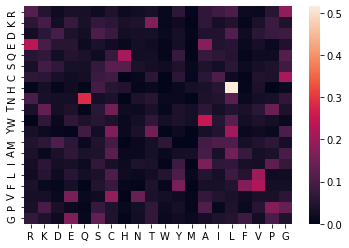

In [15]:
import seaborn as sns
sns.heatmap(MT)

### Extra: es una matriz regular?

Comprobar que la matriz de transiciones es una matriz __regular__.

In [16]:
MTdata = MT.to_numpy()
MTdataTranspose= MTdata.transpose()

numzeros0 = MTdataTranspose.shape[0]*MTdataTranspose.shape[1]-np.count_nonzero(MTdataTranspose)
matrix = np.matmul(MTdataTranspose,MTdataTranspose)
numzeros1 =MTdataTranspose.shape[0]*MTdataTranspose.shape[1]-np.count_nonzero(matrix)
numzeros0,numzeros1

(14, 0)

## Ejemplo 4. Distribución de Equilibrio

Supón que hemos llamado `MT` a la matriz de transiciones hallada en el ejercicio anterior. 

Utilizando la función __eig__ del módulo __linalg__ de __numpy__, que calcula autovalores y autovectores de una matriz cuadrada, obten las probabilidades de equilibrio asociadas a cada aminoácido según el modelo. La función eig devuelve una lista de dos
elementos:

- __eigenValues__ contiene los autovectores, 

- __eigenVectors__ es una matriz cuyas columnas son los autovectores asociados a cada autovalor (siguiendo el orden dado en values).


### Autovalores y autovectores

In [17]:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

eigVal,eigVec = np.linalg.eig(MTdataTranspose)

In [18]:
eigVal[0]

(1+0j)

In [19]:
eigVec[:,0]

array([0.2382502 +0.j, 0.24467417+0.j, 0.12601374+0.j, 0.23640415+0.j,
       0.13599602+0.j, 0.23976837+0.j, 0.34758931+0.j, 0.10802277+0.j,
       0.12708041+0.j, 0.21794427+0.j, 0.06293577+0.j, 0.19054646+0.j,
       0.04222282+0.j, 0.30020173+0.j, 0.1964877 +0.j, 0.35043236+0.j,
       0.1397589 +0.j, 0.22869757+0.j, 0.24098499+0.j, 0.34057742+0.j])

In [20]:
eigVec[:,0].dtype

dtype('complex128')

In [21]:
autovector = eigVec[:,0]
autovectorReal = np.real(autovector)
autovectorReal

array([0.2382502 , 0.24467417, 0.12601374, 0.23640415, 0.13599602,
       0.23976837, 0.34758931, 0.10802277, 0.12708041, 0.21794427,
       0.06293577, 0.19054646, 0.04222282, 0.30020173, 0.1964877 ,
       0.35043236, 0.1397589 , 0.22869757, 0.24098499, 0.34057742])

In [22]:
sum(autovectorReal)

4.114589128455469

In [23]:
# hacemos que pertenezca al simplex
autovectorRealNorm = autovectorReal/sum(autovectorReal)
autovectorRealNorm

array([0.05790376, 0.05946503, 0.03062608, 0.05745511, 0.03305215,
       0.05827274, 0.08447728, 0.0262536 , 0.03088532, 0.05296866,
       0.01529576, 0.04630996, 0.01026173, 0.07296032, 0.0477539 ,
       0.08516825, 0.03396667, 0.05558212, 0.05856842, 0.08277313])

## Ejercicio 4. Preguntas.

Observa el código del ejercicio anterior y responde a las siguientes preguntas.
1. En la teorı́a hemos visto que la distribución de equilibrio q es la solución del sistema lineal $\mathbf{q} = \mathbf{q}P$ , siendo $P$ la matriz de transiciones. ¿Por qué calculamos entonces autovalores y autovectores para hallar q?
2. ¿Por qué utilizamos la matriz transpuesta en lugar de $MT$ directamente?
3. ¿Por qué utilizamos la primera columna de la matriz de autovectores y no otra?
4. ¿Qué hace la función `np.real` que aparece en el código? ¿Por qué es necesaria?


## Ejemplo 5. Representación gráfica.

Representa gráficamente la distribución anterior mediante un diagrama de barras.
Ordena las probabilidades de mayor a menor.


In [24]:
index = np.argsort(autovectorRealNorm,)
indexDecreasing = index[::-1] # decreasing order
indexDecreasing

array([15,  6, 19, 13,  1, 18,  5,  0,  3, 17,  9, 14, 11, 16,  4,  8,  2,
        7, 10, 12])

In [25]:
len(alfabeto),len(indexDecreasing)

(20, 20)

In [26]:
alfabetoNP = np.asarray(alfabeto)
alfabetoNP

array(['R', 'K', 'D', 'E', 'Q', 'S', 'C', 'H', 'N', 'T', 'W', 'Y', 'M',
       'A', 'I', 'L', 'F', 'V', 'P', 'G'], dtype='<U1')

In [27]:
# ordenar las frecuencias del vector de estado estable
vectorEstable = autovectorRealNorm[indexDecreasing]
labels = alfabetoNP[indexDecreasing]

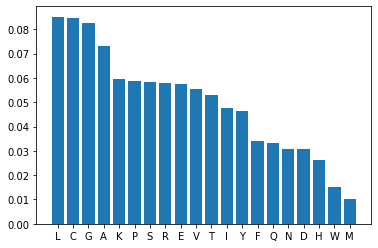

In [28]:
plt.bar(np.arange(len(vectorEstable)),vectorEstable)
plt.xticks(np.arange(len(vectorEstable)),labels)
plt.show()

## Ejercicio 5. Distribución empírica.

Calcula, contando frecuencias en el conjunto de datos, la distribucion de frecuencias relativas de los aminoácidos. Representa dos diagramas de barras superpuestos con esta distribucion y la obtenida en el Ejemplo anterior. ¿Son comparables?

In [29]:
alfabeto


Pempirica = np.zeros(lenAlfab).astype(float)
Pempirica

for nseq in range(df.shape[0]):
    secuencia = df.loc[nseq,'seq']
    for naa in range(len(secuencia)): # recorremos hasta el ultimo
        AA = secuencia[naa]
        # qué AA es?
        indexAA = alfabeto.index(AA)
        Pempirica[indexAA] += 1
print(Pempirica)

PempiricaFrecuencias = Pempirica / sum(Pempirica)
print(PempiricaFrecuencias)

[294. 304. 161. 301. 168. 302. 435. 134. 159. 269.  78. 240.  66. 388.
 242. 433. 218. 296. 295. 437.]
[0.05632184 0.05823755 0.03084291 0.05766284 0.03218391 0.05785441
 0.08333333 0.0256705  0.03045977 0.05153257 0.01494253 0.04597701
 0.01264368 0.0743295  0.04636015 0.08295019 0.04176245 0.05670498
 0.05651341 0.08371648]


In [30]:
print(np.abs(autovectorRealNorm - PempiricaFrecuencias))

print((autovectorRealNorm - PempiricaFrecuencias).max())

[0.00158192 0.00122748 0.00021683 0.00020773 0.00086824 0.00041833
 0.00114395 0.0005831  0.00042555 0.00143609 0.00035323 0.00033295
 0.00238194 0.00136918 0.00139375 0.00221806 0.00779578 0.00112287
 0.00205501 0.00094335]
0.002218058754909241


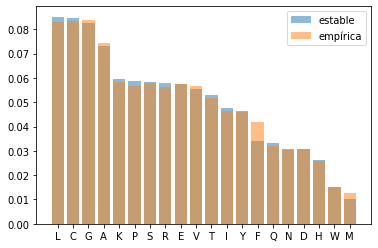

In [31]:
plt.bar(np.arange(len(vectorEstable)),vectorEstable,alpha=0.5,label='estable')
plt.bar(np.arange(len(vectorEstable)),PempiricaFrecuencias[indexDecreasing],alpha=0.5,label='empírica')
plt.xticks(np.arange(len(vectorEstable)),labels)
plt.legend()
plt.show()

## Ejercicio 6. Verosimilitudes de secuencias

Escribe una función, llamada ``myloglik``, que calcule la log-verosimilitud de una secuencia según el modelo de Markov. Los argumentos de entrada han de ser: 
   1. el vector de probabilidad inicial `vecProbInicial`
   2. la matriz de transiciones `MT`
   3. el alfabeto de 20 aminoácidos definido en el ejemplo 1 `alfabeto`
   4. la secuencia (como lista de aminoácidos) de la que queremos calcular la verosimilitud `secuencia`
   
> Tanto el vector de probabilidad inicial como la matriz de transiciones han de tener la misma ordenación que el alfabeto dado.
   
Compara las verosimilitudes de las siguientes secuencias: 

+ SEQWENCIAVERQSMILYES 
+ FVCQHLVCQHLVCQHLVCQQ.


In [32]:
def myloglik(vecProbInicial, matrizTransicion, alfa, secuencia):
    
    loglik = 0.0
    
    primeraLetra = secuencia[0]
    primeraPosicionEnAlfabeto = alfa.index(primeraLetra)
    
    loglik += np.log(vecProbInicial[primeraPosicionEnAlfabeto])
    
    for i in range(len(secuencia)-1):
        
        letraEntrada = secuencia[i]
        letraSalida = secuencia[i+1]
        
        posicionLetraEntradaAlfabeto = alfa.index(letraEntrada)
        posicionLetraSalidaAlfabeto = alfa.index(letraSalida)
        probabilidadTransicion = matrizTransicion.iloc[posicionLetraEntradaAlfabeto,
                                                 posicionLetraSalidaAlfabeto]
        
        loglik += np.log(probabilidadTransicion)
    return loglik

In [33]:
secuencia1 = "SEQWENCIAVERQSMILYES"
loglik1 = myloglik(Pini, MT, alfabeto, secuencia1)
lik1=np.exp(loglik1)
print(secuencia1,'\nLoglikelihood: {}\nLikelihood:: {}\n'.format(loglik1,lik1))

secuencia2 = "FVCQHLVCQHLVCQHLVCQQ"
loglik2 = myloglik(Pini, MT, alfabeto, secuencia2)
lik2=np.exp(loglik2)
print(secuencia2,'\nLoglikelihood: {}\nLikelihood:: {}\n'.format(loglik2,lik2))

SEQWENCIAVERQSMILYES 
Loglikelihood: -64.0330953932442
Likelihood:: 1.5516008595950296e-28

FVCQHLVCQHLVCQHLVCQQ 
Loglikelihood: -38.54576794984071
Likelihood:: 1.8188030702995e-17

